In [1]:
import pandas as pd
import numpy as np

import calendar
import datetime
from datetime import date

import snscrape.modules.twitter as sntwitter
from tqdm.notebook import tqdm_notebook

from wordcloud import WordCloud
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline

import nltk
#nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

import requests
import re

import warnings
warnings.filterwarnings("ignore")


all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

## Fetch today's tweets

In [3]:
def get_todays_tweets(max_tweets):
    
    # Get today's date
    t = date.today()
    today = t.strftime('%Y-%m-%d')
    
    # Setup hashtags and search parameters
    hashtags = '#Putin OR #Zelenski OR #Ukraine OR #Russia OR #UkraineRussiaWar OR #russia OR #ukraine OR #Russian OR #Ukranian'
    since = today
    query = '{hashtag} since:{today} lang:"en"'.format(today = today,hashtag = hashtags)
    
    # Limit to 100k
    limit = max_tweets
    tweets = []
    
    # Scrape for the tweets
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        if len(tweets) == limit:
            break
        else:
            if pd.notnull(tweet.viewCount):
                tweets.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username,tweet.lang,
                tweet.hashtags,tweet.replyCount,tweet.retweetCount,tweet.likeCount,tweet.viewCount])
    
    # Read as dataframe
    scraped_tweets = pd.DataFrame(tweets, columns = ['DateTime', 'Id', 'Tweet', 'Username','Language',
                                    'Hashtags','Reply_Count','Retweet_Count','Likes_Count','Views'])
    
    # PRE-PRROCESS THE DATA
    
    # Create the date and time columns from DateTime and drop Datetime
    scraped_tweets['date'] = scraped_tweets['DateTime'].dt.date
    scraped_tweets['time'] = scraped_tweets['DateTime'].dt.time
    scraped_tweets = scraped_tweets.drop(['DateTime'],axis = 1)
    
    scraped_tweets = bots_removal(scraped_tweets)
    
    return scraped_tweets
    

## Bots removal

In [4]:
def bots_removal(df):
    before =  df.shape[0]
    print("Size of dataframe before removal: ", before)
    
    # Remove bots from today's tweets
    counts = df.drop(['Id','date','time','Language','Hashtags'], axis = 1)
    accounts = counts.groupby('Username').sum()
    tweets_count = counts.groupby('Username').count().sort_values(by = 'Tweet', ascending = False)
    
    # Find the bots
    Bots = tweets_count[tweets_count['Tweet'] > 25]
    Bots = Bots.reset_index()
    unique_bot_users  = Bots['Username'].drop_duplicates().to_frame()
    unique_bot_users_list = unique_bot_users['Username'].tolist()

    # clean dataset
    df = df[~df['Username'].isin(unique_bot_users_list)].reset_index(drop=True)
    
    # Print additional info
    after = df.shape[0]
    print("Size of dataframe before removal: ", after)
    print("Number of potential bot tweets removed: ", before - after)
    return df

## Plots

In [5]:
def plot_top10(df,plot_style):
    
    # Create the necessary grouped and summarised dataframes
    counts = df.drop(['Id','date','time','Language','Hashtags'], axis = 1)
    accounts = counts.groupby('Username').sum()
    tweets_count = counts.groupby('Username').count().sort_values(by = 'Tweet', ascending = False)
    
    # Get top 10 counts for each feature
    df_names = ['top_views','top_replies','top_retweets','top_likes']
    column_names = ['Views','Reply_Count','Retweet_Count','Likes_Count']

    for df_name, column in zip(df_names,column_names):
        globals()[df_name] = accounts.sort_values(by=column,ascending = False).head(10)

    top_tweets = tweets_count.sort_values(by='Tweet', ascending = False).head(10)
    
    if plot_style == 'interactive':
    
        # Plot the top 10 for each feature
        fig = make_subplots(rows=2, cols=2, shared_yaxes=False,
                        subplot_titles=("Likes/Tweet","Views/Tweet", "Retweets","Replies")
                        ,vertical_spacing = 0.3)

        fig.add_trace(go.Bar(x=top_likes.index, y=top_likes['Likes_Count']),1, 1)
        fig.add_trace(go.Bar(x=top_views.index, y=top_views['Views']),1, 2)
        fig.add_trace(go.Bar(x=top_retweets.index, y=top_retweets['Retweet_Count']),2, 1)
        fig.add_trace(go.Bar(x=top_replies.index, y=top_replies['Reply_Count']),2, 2)

        # Update yaxis properties
        fig.update_xaxes(tickangle=-25, row=1, col=1)
        fig.update_xaxes(tickangle=-25, row=1, col=2)
        fig.update_xaxes(tickangle=-25, row=2, col=1)
        fig.update_xaxes(tickangle=-25, row=2, col=2)

        fig.update_layout(height=600, width=850,showlegend=False, title_text = "Top 10 Users for relevant features",
                          title_x=0.5)
        fig.show()

        
    elif plot_style == 'professional':
        
        # Plot the top 5 for each feature
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14,9))
        sns.set_style("whitegrid")
        a = sns.barplot(x = top_likes.index, y = 'Likes_Count', data = top_likes, ax=axs[0,0], alpha = 0.5, color = 'cadetblue')
        a.set_xticklabels(a.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
        a.set_title('Likes/Tweet')


        b = sns.barplot(x = top_views.index, y = 'Views', data = top_views, ax=axs[0,1], alpha = .5, color = 'cadetblue')
        b.set_xticklabels(b.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
        b.set_title('views/Tweet')

        c = sns.barplot(x = top_retweets.index, y = 'Retweet_Count', data= top_retweets, ax=axs[1,0], alpha = 0.5, color = 'cadetblue')
        c.set_xticklabels(c.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
        c.set_title('Retweets')

        d = sns.barplot(x = top_replies.index, y = 'Reply_Count', data= top_replies, ax=axs[1,1], alpha = .5, color = 'cadetblue')
        d.set_xticklabels(d.get_xticklabels(), rotation = 25, horizontalalignment = 'right')
        d.set_title('Replies')

    return plt.tight_layout()

In [6]:
def daily_plots(df1,df2,feature):
    
    if feature == 'tweets':
    # Group by
        bydate_w = df1.groupby("date").count()
        bydate_r = df2.groupby("date").count()
    else:
        bydate_w = df1.groupby("date").sum()
        bydate_r = df2.groupby("date").sum()
    
    fig = plt.figure(figsize=(17,10))

    if feature == 'tweets':
        y_axis = 'Tweet'
        title = 'Tweets/day'
    elif feature == 'views':
        y_axis = 'Views'
        title = 'Views/day'
    elif feature == 'retweets':
        y_axis = 'Retweet_Count'
        title = 'Retweets/day'
    elif feature == 'replies':
        y_axis = 'Reply_Count'
        title = 'Replies/day'

    a = sns.lineplot(x = bydate_w.index, y =y_axis, data = bydate_w, color = 'cadetblue')
    a = sns.lineplot(x = bydate_r.index, y =y_axis, data = bydate_r, color = 'indianred')
    a.tick_params(axis='x', rotation=90, labelsize = 14)
    a.set_title(title)
    
    return plt.tight_layout()

## Remove emojis & signs

In [7]:
def remove_emojis(df):
    df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    return df

In [8]:
def remove_signs(df):
    
    text_df = ''
    for tweet in df['Tweet']:
        text_df += tweet
    
    text_df = re.sub(r"http\S+", "", text_df)
    text_df = text_df.replace("@", "")
    text_df = text_df.replace("#", "")
    text_df = text_df.replace(".", ".<eos>")
    text_df = text_df.replace("!", ".<eos>")
    text_df = text_df.replace("?", ".<eos>")
    
    sentences_df = text_df.split("<eos>")

    new_sentences_df = []
    for sen in sentences_df:
        if len(sen) < 5:
            continue
        else:
            new_sentences_df.append(re.sub(' +', ' ', sen)) # remove extra spaces
    
    return new_sentences_df

## WordCloud

In [9]:
def hashtags_wordcloud(df,hashtags):
    
    # Drop na values from Hashtags
    df = df.dropna(subset=['Hashtags'])
    
    # Create the count dataframe for WordCloud
    hashtags_series = df['Hashtags'].apply(pd.Series).stack().value_counts()
    df = hashtags_series.to_frame().reset_index()
    df.columns = ['Hashtag','Count']
    
    # If False then do not include the main war hashtags
    if hashtags == False:
        hashtags = ['Ukraine','Russia','Putin','UkraineRussiaWar','Zelensky','Russian','ukraine','UkraineWar','russia','Ukrainian','UkraineRussianWar']
        df = df[~df['Hashtag'].isin(hashtags)]
    else:
        pass
    
    # Load the mask image
    mask = np.array(Image.open("C:/Users/Mikic/Downloads/twitter_mask.png"))
    mask = mask[:, :, :3]

    # Generate the wordcloud
    wordcloud = WordCloud(background_color="#1DA1F2",colormap='RdGy_r', collocations=False,
                          mask=mask, max_words = 5000,font_path='arial').generate(' '.join(df['Hashtag'].tolist()))

    # Get the wordcloud array and create a background array with the same shape
    background = np.ones((mask.shape[0], mask.shape[1], 3), dtype=np.uint8) * 255
    wordcloud_array = wordcloud.to_array()

    # Set the pixels inside the mask to the wordcloud colors
    mask_inv = np.invert(mask.astype(bool))
    background[mask_inv] = wordcloud_array[mask_inv]

    # Display the combined image
    plt.figure()
    plt.imshow(background, interpolation="bilinear")
    #plt.savefig("twitter_mask.png", format="png")
    #plt.savefig("background.png", format="png")
    plt.axis("off")
    
    return plt.show()

## Sorting Tweets

In [10]:
def tweets_sort(df, sort_type,top_or_bottom):
    
    top_tweets = []
    bottom_tweets = []
    
    if sort_type == 'likes':
        column = 'Likes_Count'
        title_1 = 'Most liked Tweets'
        title_2 = 'Most disliked Tweets'
        
    elif sort_type == 'retweets':
        column = 'Retweet_Count'
        title_1 = 'Most retweeted Tweets'
        title_2 = 'Least retweeted Tweets'
        
    elif sort_type == 'replies':
        column = 'Reply_Count'
        title_1 = 'Most replied to Tweets'
        title_2 = 'Least replied to Tweets'
    
    elif sort_type != 'likes' and top_or_bottom != 'retweets' and top_or_bottom != 'replies':
        print("Wrong 2nd input, please input one of the following: 'likes', 'retweets', 'replies'")
        
    if top_or_bottom == 'top':
        print(title_1)
        test = df[['Tweet',column]].sort_values(by = column, ascending = False)[:10]
        test = test.drop(column,axis=1).reset_index(drop=True)
        return test.style
    
    elif top_or_bottom == 'bot':
        print(title_2)
        test = df[['Tweet',column]].sort_values(by = column, ascending = True)[:10]
        test = test.drop(column,axis=1).reset_index(drop=True)
        return test.style
    
    elif top_or_bottom != 'top' and top_or_bottom != 'bot':
        print("Wrong 3rd input, please input 'top' or 'bot'")

## Sentiment Analysis

In [11]:
# list of more than 1000 english stopwords; using requests to get the list
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [12]:
def tweets_corupus(df):
    # Get corpus
    corpus_tweet = []
    for tweet in df['Tweet']:
        corpus_tweet.append(tweet)
    return corpus_tweet

In [13]:
def tweet_process(tweet):
    tweet = re.sub('[^^a-zA-Z]', ' ', tweet) # repleace everything that is not a-zA-Z with ' ' from data[i]
    tweet = tweet.lower() # lower
    tweet = [word for word in tweet.split() if word not in stopwords] # remove stopwards but from stopords2 list (not nltk lis)
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    tweet = [lemmatizer.lemmatize(word) for word in tweet]
    return(tweet)

In [14]:
def create_frequency(tweets, ys):
    
    freq_d = {}
    
    for tweet, y in zip(tweets, ys):
        for word in tweet_process(tweet):
            
            pair = (word, y)
            
            if pair in freq_d:
                freq_d[pair] += 1
            else:
                freq_d[pair] = freq_d.get(pair, 1) 
    
    return freq_d

In [15]:
def train_naive_bayes(freqs, train_x, train_y):
    
    loglikelihood = {}
    logprior = 0
    
    # calculate the number of unique words in vocab
    unique_words = set([pair[0] for pair in freqs.keys()])
    V = len(unique_words)
    
    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        
        # TODO: get N_pos and N_get
        if pair[1] > 0:
            N_pos += freqs[(pair)]
            
        else:
            N_neg += freqs[(pair)]
            
    # TODO: calculate the number of documents (tweets)
    D = train_y.shape[0]
    
    # TODO: calculate D_pos, the number of positive documents (tweets)
    D_pos = sum(train_y)
    
    # TODO: calculate D_neg, the number of negative documents (tweets)
    D_neg = D - sum(train_y)
    
    # TODO: calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    # for each unqiue word
    for word in unique_words:
        
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)
        
        # calculate the probability that word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
        
    return logprior, loglikelihood

In [16]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def naive_bayes_predict(tweet, logprior, loglikelihood):

    # TODO: process the tweet to get a list of words
    word_l = tweet_process(tweet)

    # TODO: initialize probability to zero
    p = 0

    # TODO: add the logprior
    p += logprior

    for word in word_l:

        # TODO: get log likelihood of each keyword
        if  word in loglikelihood:
            p += loglikelihood[word]

    return p

## Sentiment running functions

In [18]:
def varName(p):
    for k, v in globals().items():
        if id(p) == id(v):
            return k

In [19]:
def korpus(df):
    
    #Remove emojis
    df = remove_emojis(df)
    
    #Get corpus of tweets
    corpus_tweet = tweets_corupus(df)
    korpus = []
    
    for tweet in corpus_tweet:
        korpus.append(tweet_process(tweet))
    return korpus

In [20]:
def create_sentiment(df):
    df = remove_emojis(df)
    
    # Get test and train data for both negative and positive data
    test_pos = all_positive_tweets[4000:]
    train_pos = all_positive_tweets[:4000]
    test_neg = all_negative_tweets[4000:]
    train_neg = all_negative_tweets[:4000]
    
    # Create the train data
    train_x = train_pos + train_neg
    test_x = test_pos + test_neg

    #Create the test data
    train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
    test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))
    
    # Build the freqs dictionary
    freqs = create_frequency(train_x, train_y)
    
    # Train Naive Bayes
    logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
    
    # Prepare the dataset for sentiment assignation
    df['Tweet'] = df['Tweet'].astype('string') 

    my_list = df['Tweet'].tolist()

    # Run the model
    p_list = []
    for tweet in my_list:
        p = naive_bayes_predict(tweet, logprior, loglikelihood)
        p_list.append(p)

    df1 = pd.Series(p_list)
    ndf1 = df1.to_frame(name = 'p')
    
    # Assign the sentiment
    df['Sentiment'] = p_list
    return df

In [21]:
def multi_sentiment_histplot(west,rus,large,daily):
    
    # Calculate Sentiment Scores
    west = create_sentiment(west)
    rus = create_sentiment(rus)
    large = create_sentiment(large)
    daily = create_sentiment(large)
    
    # Plot Sentiment score
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,12))

    w = sns.histplot(west['Sentiment'], bins=40, color = 'cadetblue', kde = True, ax = axs[0,0])
    w.set_title("Western - sentiment score distribution")
    r = sns.histplot(rus['Sentiment'], bins=40, color = 'indianred', kde = True, ax = axs[0,1])
    r.set_title('Russian - sentiment score distributution')
    l = sns.histplot(large['Sentiment'], bins=40, color = 'indianred', kde = True, ax = axs[1,0])
    l.set_title('General Population - sentiment score distributution')
    d = sns.histplot(daily['Sentiment'], bins=40, color = 'indianred', kde = True, ax = axs[1,1])
    d.set_title('Tweets from Today - sentiment score distributution')
    fig.tight_layout()
    
    return plt.show()

In [22]:
def boxplot_accounts_sentiment(west,rus):
    
    # Calculate Sentiment Scores
    west = create_sentiment(west)
    rus = create_sentiment(rus)
    
    # Plot Sentiment boxplot for the accounts
    
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20,12))
    w = sns.boxplot(x="Username", y="Sentiment", data=west, color='cadetblue', ax = axs[0])
    w.tick_params(axis='x', rotation=33, labelsize = 14)
    w.set_title("Western Accounts BoxPlot")
    r = sns.boxplot(x="Username", y="Sentiment", data=rus, color='indianred', ax = axs[1])
    r.tick_params(axis='x', rotation=33, labelsize = 14)
    r.set_title("Russian Accounts BoxPlot")
    fig.tight_layout()

    return plt.show()

## Text Summarization

In [23]:
def SummariseText(df):
    new_sentences_df = remove_signs(df)
    
    summarizer = pipeline("summarization")

    max_chunk = 500
    current_chunk = 0 
    chunks = []
    for sentence in new_sentences_df:
        if len(chunks) == current_chunk + 1: 
            if len(chunks[current_chunk]) + len(sentence.split(' ')) <= max_chunk:
                chunks[current_chunk].extend(sentence.split(' '))
            else:
                current_chunk += 1
                chunks.append(sentence.split(' '))
        else:
            print(current_chunk)
            chunks.append(sentence.split(' '))

    for chunk_id in range(len(chunks)):
        chunks[chunk_id] = ' '.join(chunks[chunk_id])
        
    result_df = summarizer(chunks, max_length=120, min_length=30, do_sample=False)
                                           
    Summary_df = ''
    for i in range(len(result_df)):
        Summary_df += result_df[i]['summary_text']
                                     
    return Summary_df

# Run

Waiting for scraping of today's tweets... 

Removing Tweets from Bots... 

Size of dataframe before removal:  100
Size of dataframe before removal:  100
Number of potential bot tweets removed:  0
Databases loaded! 

Creating WordCloud for Today's Tweets...


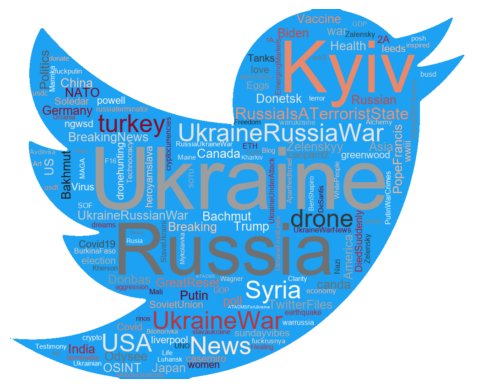

Plotting today's top 10 accounts for each feature...


What type of plot do yo want (tweets,views,retweets,replies): tweets
Plotting Westeners vs Russians Number of Tweets per Day...
What type of feature would you like to be sorted (likes,retweets,replies)? likes
Showing the top 10 most liked tweets...
Most liked Tweets
Plotting sentiment analysis subplots...


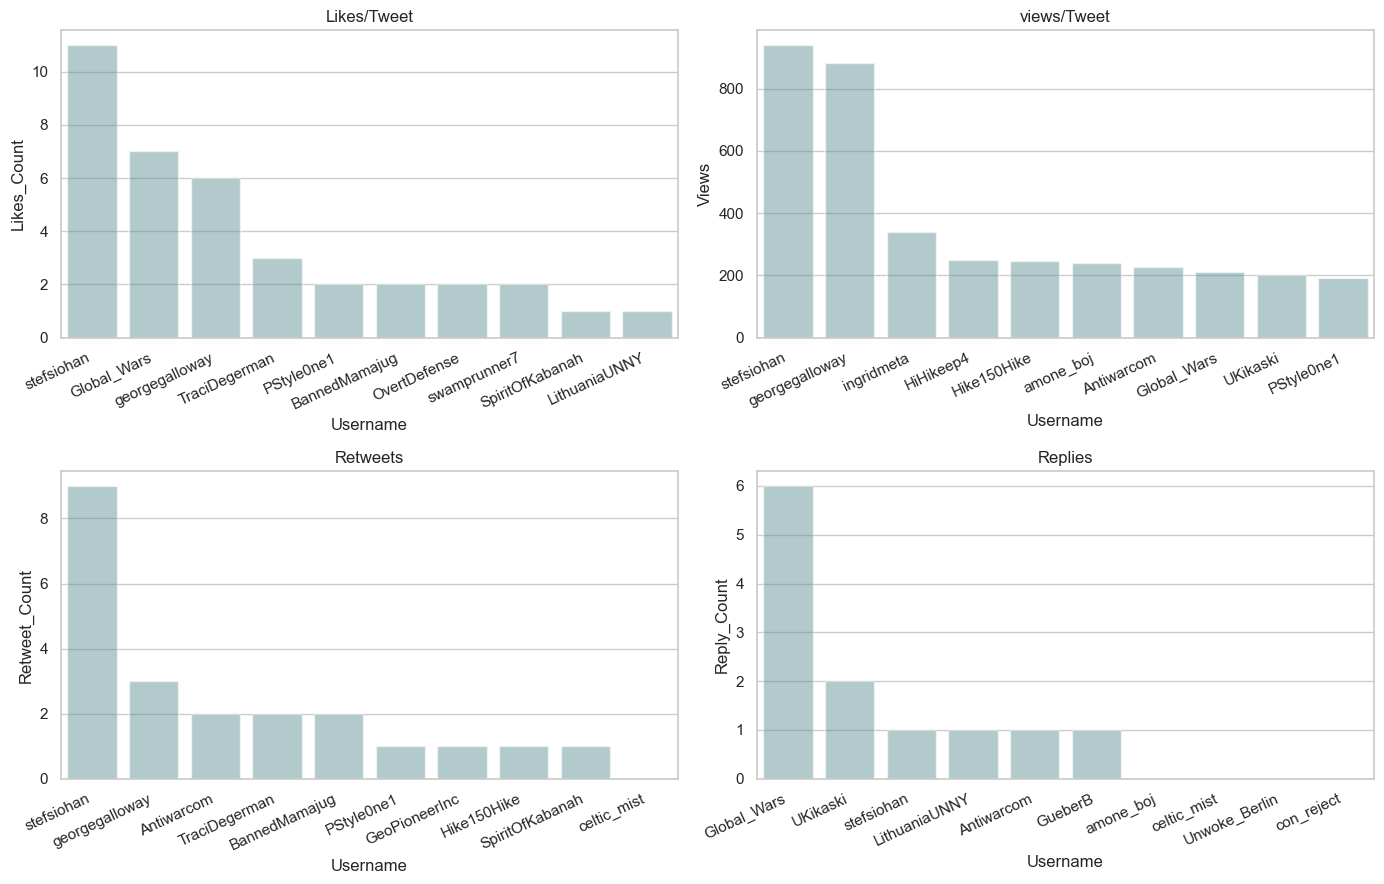

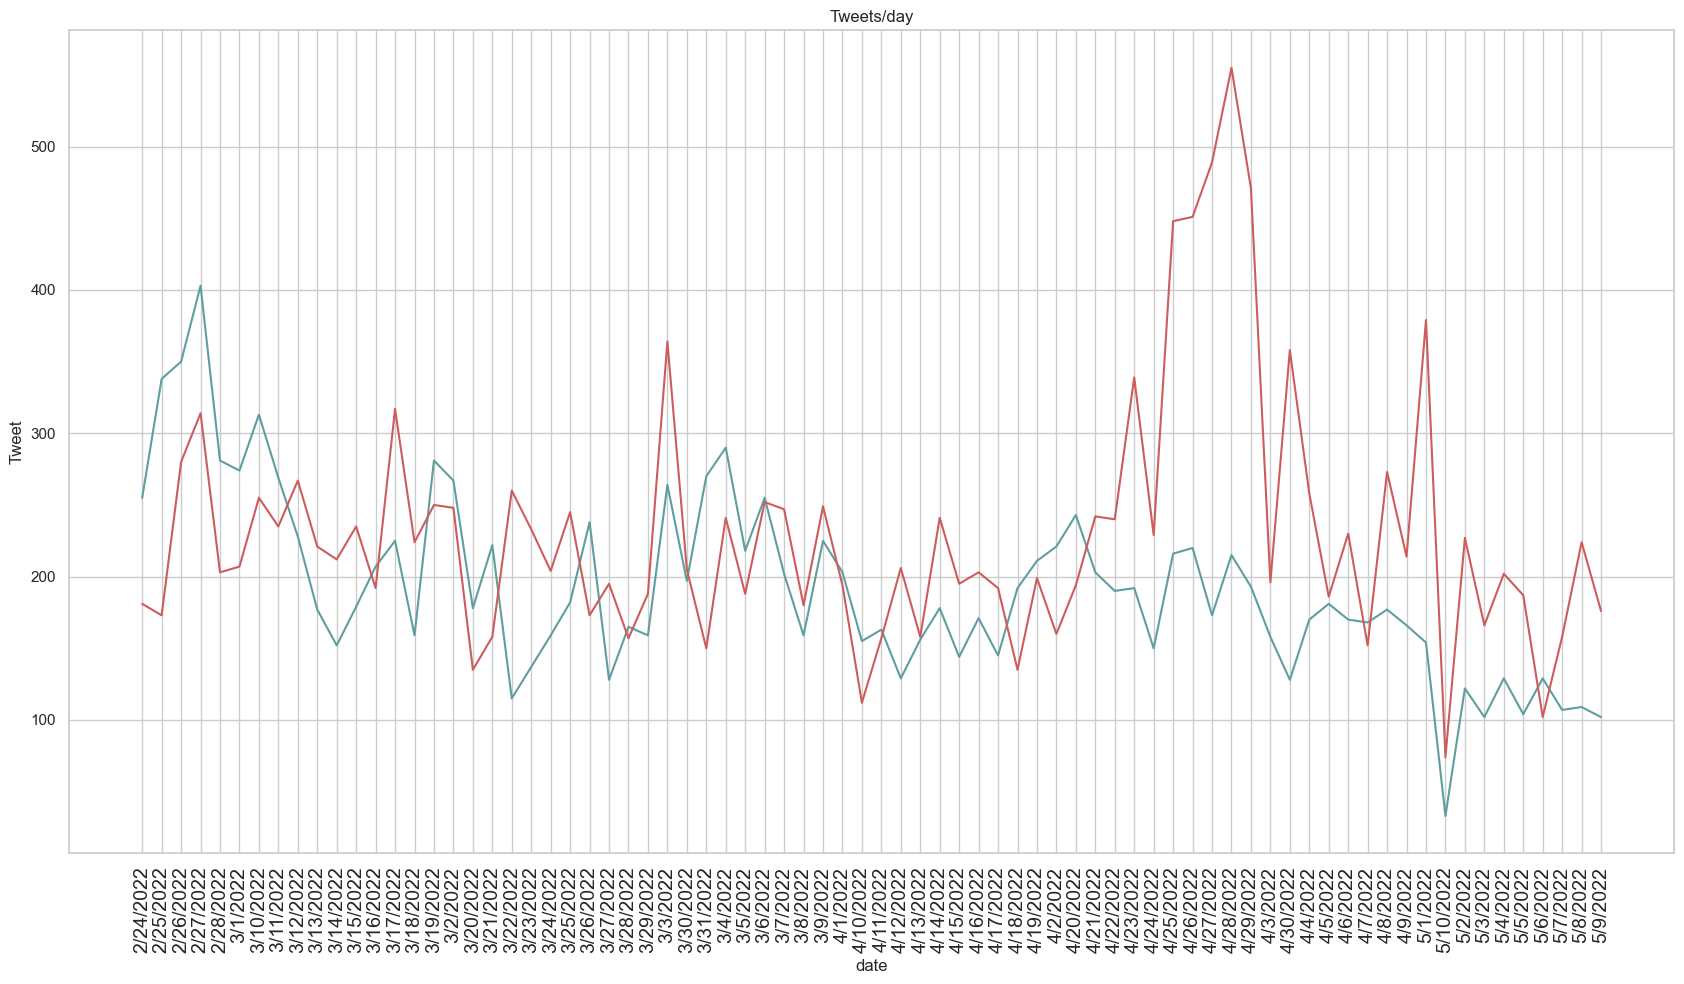

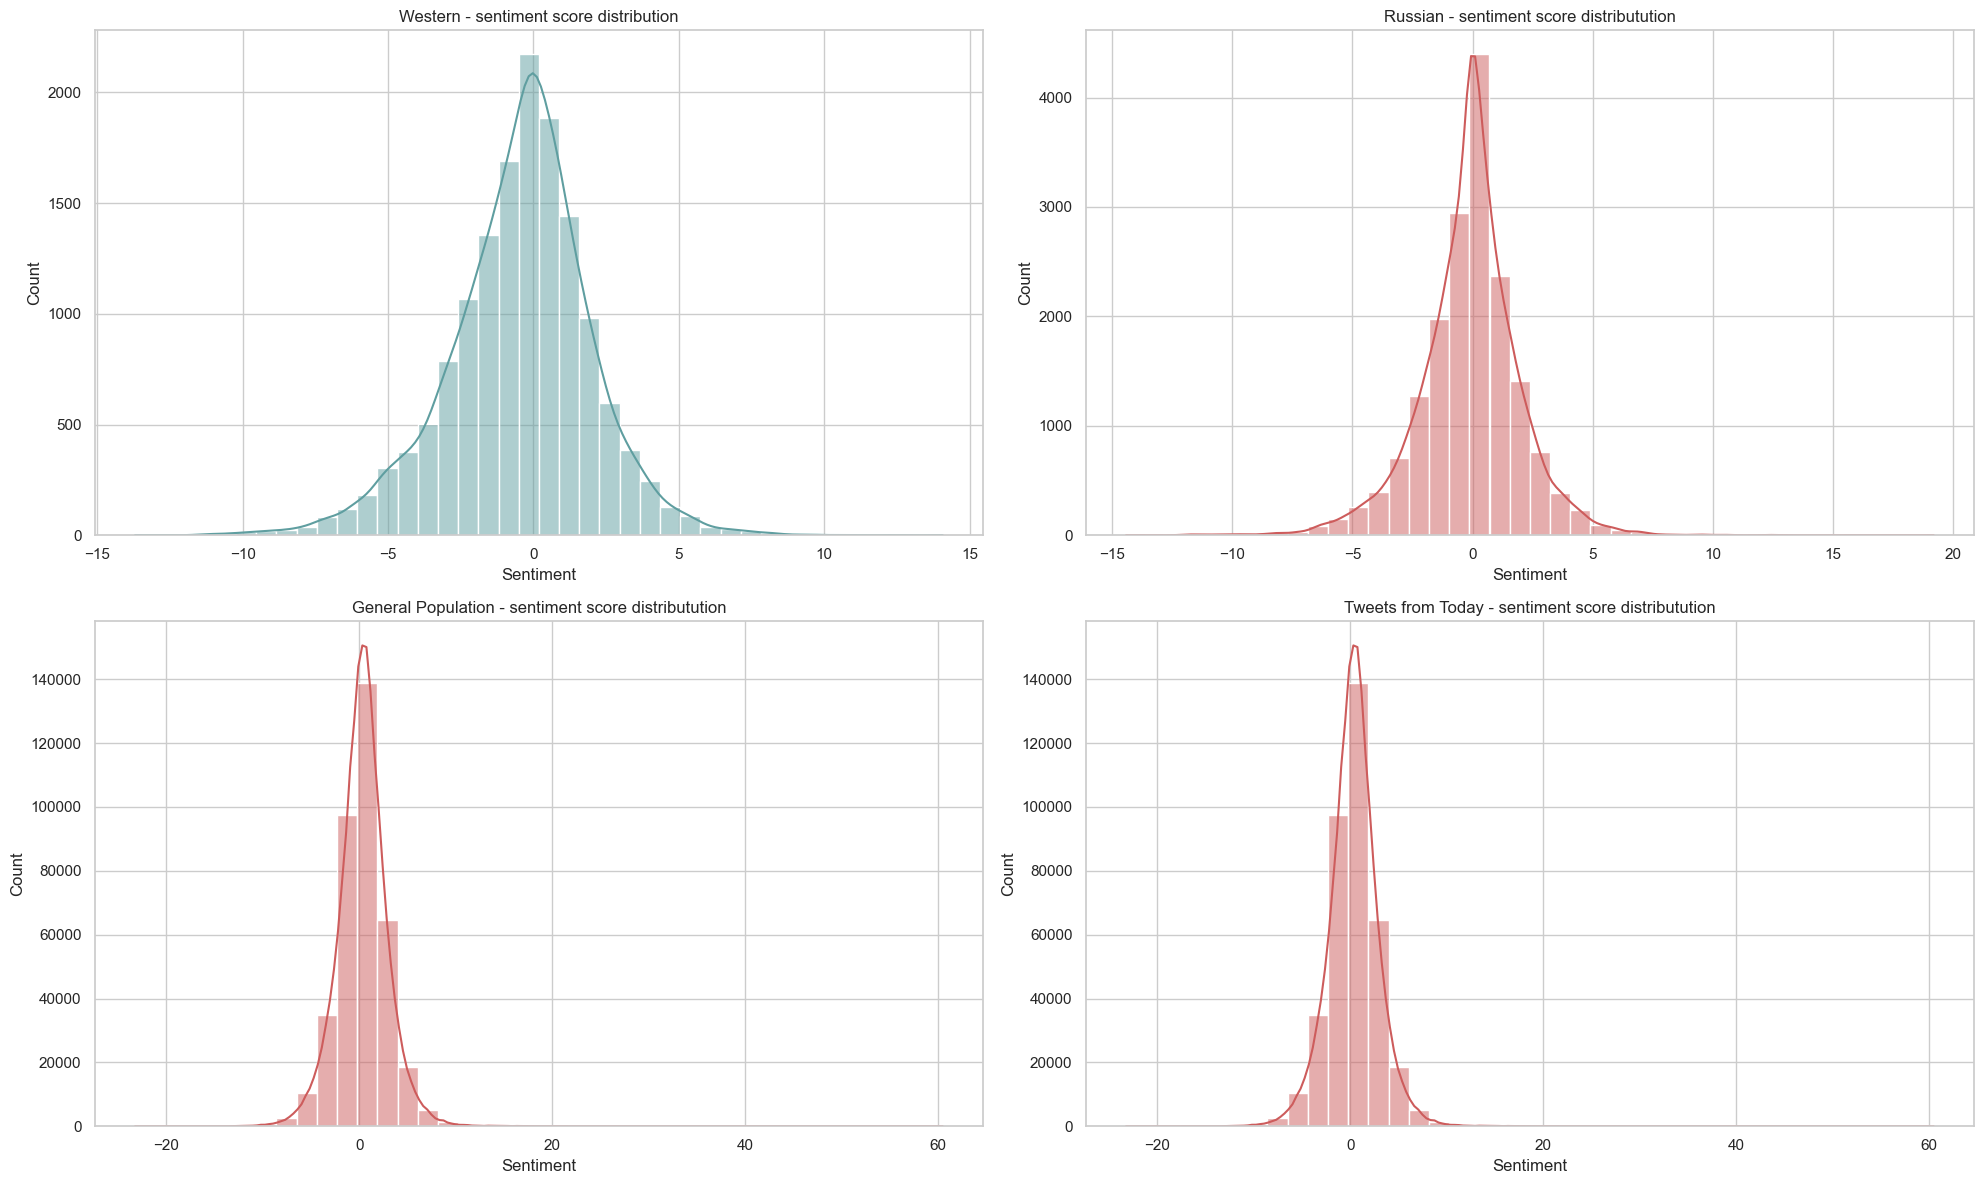

Plotting account sentiment boxplots...


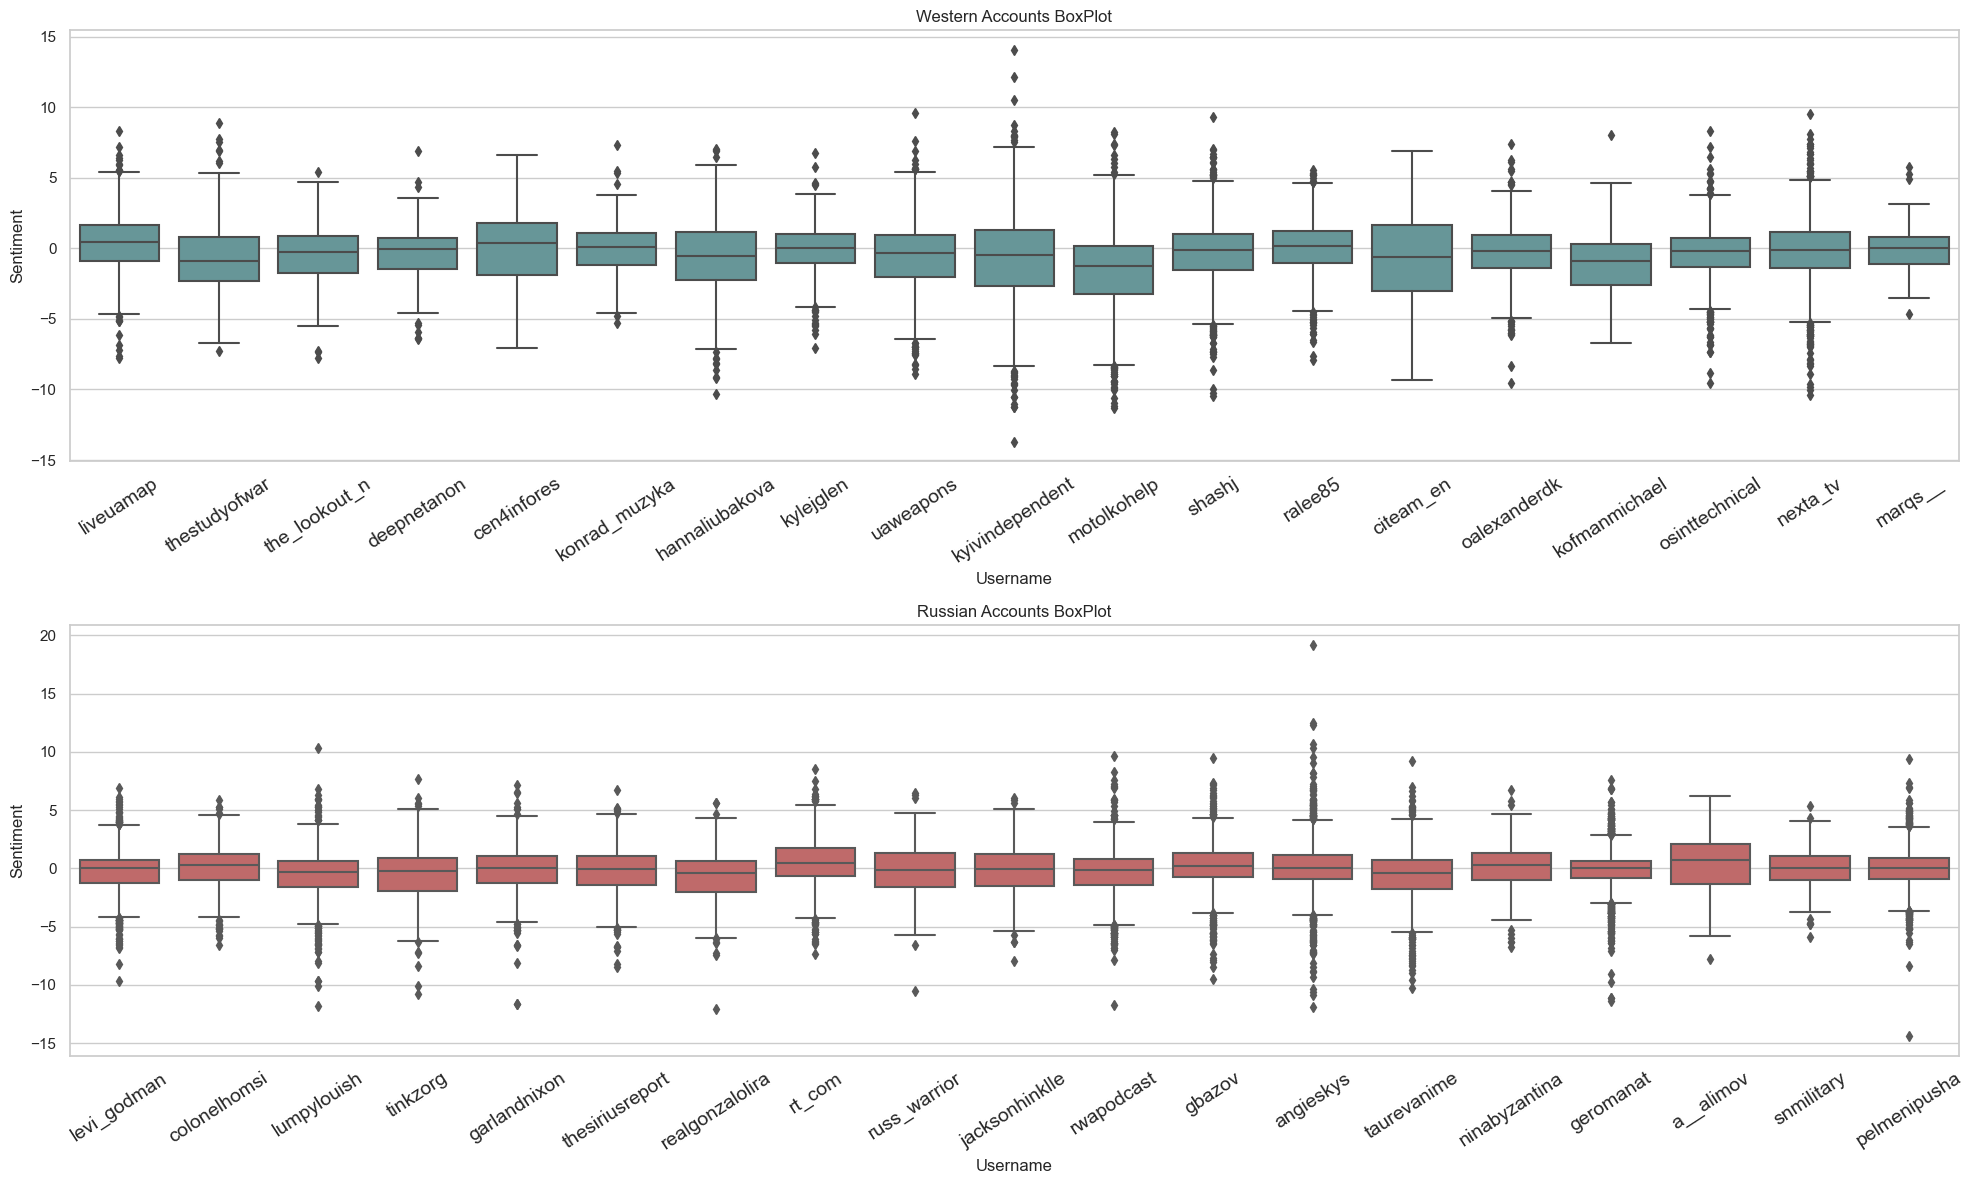

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Summarizing today's tweets...
0


KeyboardInterrupt: 

In [24]:
from time import sleep

def main():
    
    general_pop = pd.read_feather("C:/Users/Mikic/DSI-Project/Data/375k_tweets.feather")
    russian = pd.read_csv("C:/Users/Mikic/DSI-Project/Data/RuTrolls_tweets_UNIFORM.csv")
    western = pd.read_csv("C:/Users/Mikic/DSI-Project/Data/western_tweets_UNIFORM.csv")
    
    print("Waiting for scraping of today's tweets...","\n")
    sleep(5)
    
    print("Removing Tweets from Bots...","\n")
    today = get_todays_tweets(100)
    
    print("Databases loaded!","\n")
    sleep(3)

    print("Creating WordCloud for Today's Tweets...")
    hashtags_wordcloud(today,True)
    sleep(5)
    
    print("Plotting today's top 10 accounts for each feature...")
    sleep(1)
    plot_top10(today,"professional")
    sleep(3)

    print()
    print()
    plot_type = input("What type of plot do yo want (tweets,views,retweets,replies): ")
    if plot_type == "tweets":
        print("Plotting Westeners vs Russians Number of Tweets per Day...")
    elif plot_type == "views":
        print("Plotting Westeners vs Russians Tweet Views per Day...")
    elif plot_type == "retweets":
        print("Plotting Westeners vs Russians Number of Retweets per Day...")
    elif plot_type == "replies":
        print("Plotting Westeners vs Russians Number of Replies to Tweets per Day...")
    else:
        print("Wrong input!!! Use one of the examples given!")
    
    daily_plots(western,russian,plot_type)
    
    feature_type = input("What type of feature would you like to be sorted (likes,retweets,replies)? ")
    
    if feature_type == "likes":
        print("Showing the top 10 most liked tweets...")
    elif feature_type == "retweets":
        print("Showing the top 10 most retweeted tweets...")
    elif feature_type == "replies":
        print("Showing the top 10 most replied to tweets...")
    else:
        print("Wrong input!!! Use one of the examples given!")
    
    tweets_sort(today,feature_type,"top")
    
    print("Plotting sentiment analysis subplots...")
    multi_sentiment_histplot(western,russian,general_pop,today)
    
    print("Plotting account sentiment boxplots...")
    boxplot_accounts_sentiment(western,russian)
    
    print("Summarizing today's tweets, it might take a while...")
    SummariseText(today)
    
    print("All done!")

if __name__ == "__main__":
    main()